This notebook gets the results for the evaluation from the comet machine learning api and plot them.
All the plots of BERT scores as a function of the group size.

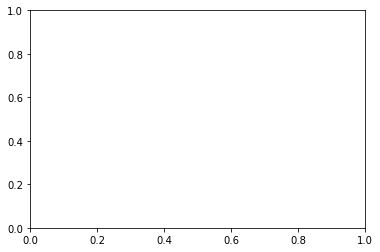

In [1]:
from IPython.display import display, Markdown
import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from evaluation.plot_results_functions import generate_plot, stat_names, plot_duration, X_LABEL

# BERT Scores as a function of group size

## mean

<Figure size 432x288 with 0 Axes>

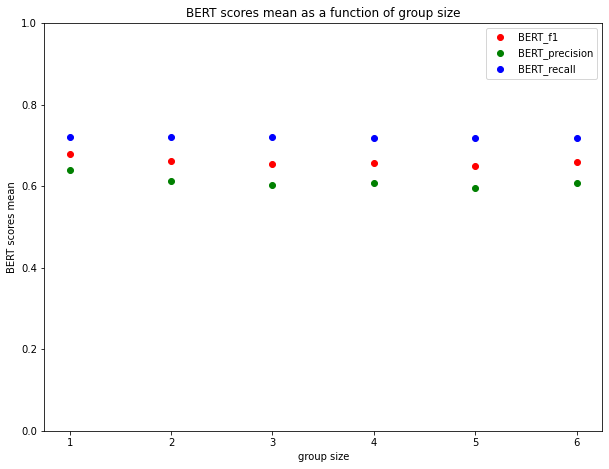

## median

<Figure size 432x288 with 0 Axes>

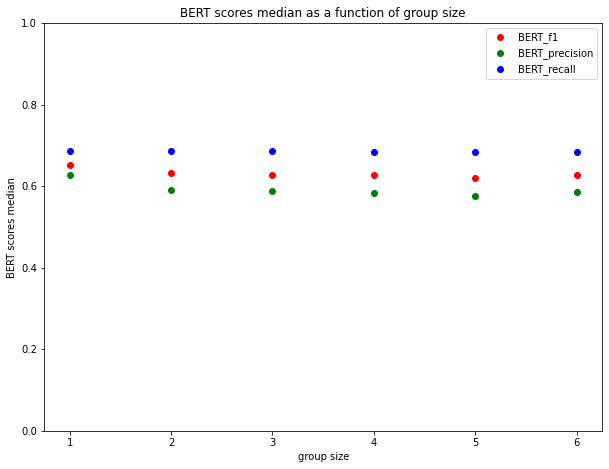

## 25_percentile

<Figure size 432x288 with 0 Axes>

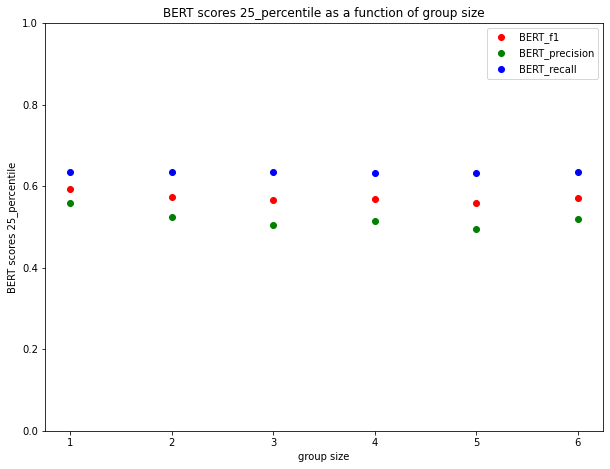

## 75_percentile

<Figure size 432x288 with 0 Axes>

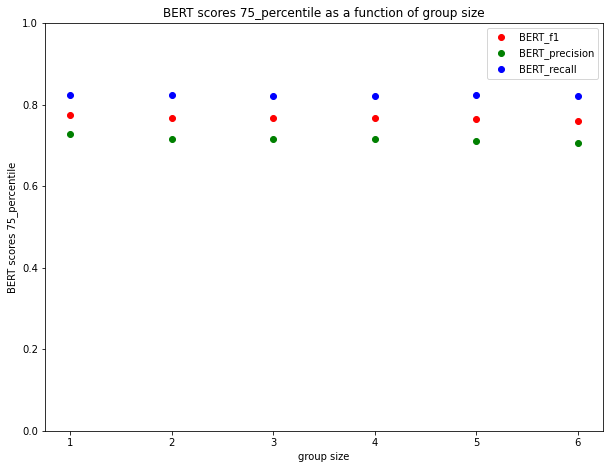

## min

<Figure size 432x288 with 0 Axes>

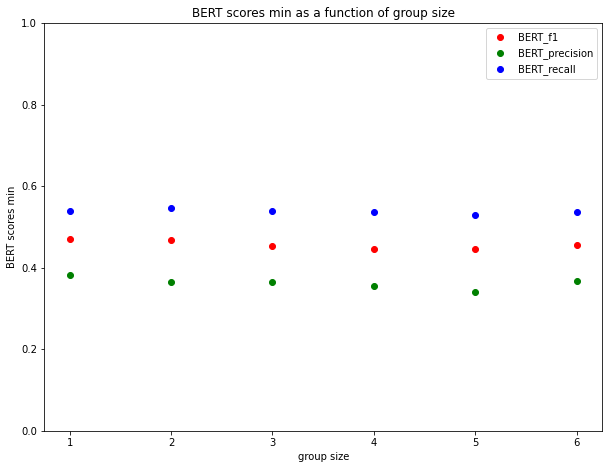

## max

<Figure size 432x288 with 0 Axes>

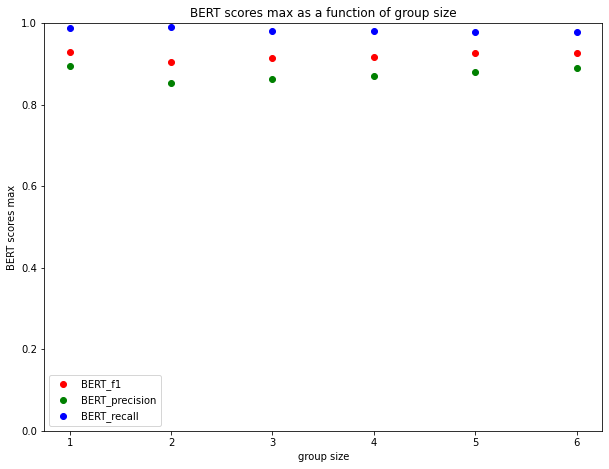

## standard_deviation

<Figure size 432x288 with 0 Axes>

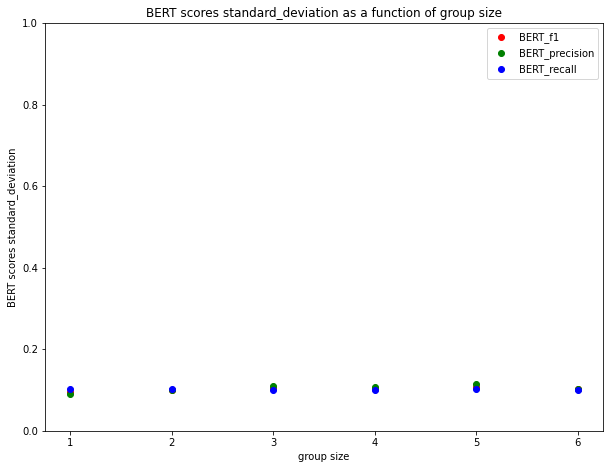

# Experiment duration as a function of group size

<Figure size 432x288 with 0 Axes>

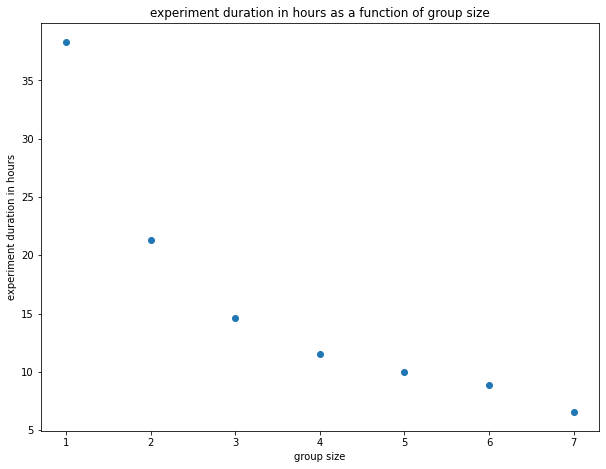

<Figure size 432x288 with 0 Axes>

In [2]:
display(Markdown(f"# BERT Scores as a function of {X_LABEL}"))
for current_stat in stat_names:
    generate_plot(current_stat)

display(Markdown(f"# Experiment duration as a function of {X_LABEL}"))
plot_duration()